<h1><center>Email Spam Classifier</center></h1>

This project is based on Manning's Transfer Learning for NLP in chapter 2

In [1]:
import pandas as pd
import numpy as np
import email
import os
import pickle

Define data file path, i.e., directory where data to train the classifier is. As this is a csv type the file is loaded with pandas read_csv function. If successfull the number of rows and columns with the first 5 rows are printed.

In [2]:
data_file_path = "/home/baosiek/Documents/deep_learning/transfer-learning/data/emails.csv"
emails = pd.read_csv(data_file_path)
print("Emails were loaded successfully containing {} rows and {} columns".format(emails.shape[0], emails.shape[1]))
print("Printing 5 first rows...")
print(emails.head(5))

Emails were loaded successfully containing 517401 rows and 2 columns
Printing 5 first rows...
                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...


Prints the contect of the first email, under the message column, enabling data understanding.

In [3]:
print(emails.loc[0, "message"])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


Lets get only the text part of the message, discarding date, from, to and Subject info. 

In [4]:
def extract_text(emails):

    # Initializes a list of texts where each row will contain only the content of the email
    contents = []
    
    for item in emails["message"]:
        e = email.message_from_string(item)
        content = e.get_payload() # Gets only a string with the email content
        contents.append(content)
        
    return contents

In [5]:
# This process may take sometime. So we first check if the emails were already
# processed with their respective content in a list. If this data is not found this 
# procedure extracts the content from the emails and stores it.
if not os.path.exists('/home/baosiek/Documents/deep_learning/transfer-learning/data/contents.txt'):
    contents = extract_text(emails)
    with open("./data/contents.txt", "wb") as fp:   # Serializing
        pickle.dump(contents, fp)
else:
    with open("./data/contents.txt", "rb") as fp:   # Deserializing
        contents = pickle.load(fp)
        

# Prints the content at row 100
print(contents[100])

I tried the new address but I don't have access.  also, what do I need to 
enter under domain?


Testing if number of rows in emails data frame and contents list data structure are equal.

In [6]:
if len(contents) == emails.shape[0]:
    print("Success!")

Success!


Converts contents list into a data frame and prints the first 5 emails contents

In [7]:
contents_df = pd.DataFrame(contents)
print(contents_df.head(n=5))

                                                   0
0                          Here is our forecast\n\n 
1  Traveling to have a business meeting takes the...
2                     test successful.  way to go!!!
3  Randy,\n\n Can you send me a schedule of the s...
4                Let's shoot for Tuesday at 11:45.  


# The Spam dataset

In [8]:
data_file_path = "/home/baosiek/Documents/deep_learning/transfer-learning/data/fradulent_emails.txt"
with open(data_file_path, 'r', encoding='latin1') as file:
    spams = file.read()
# spams is a long string beacause originally the data downloaded is a single text file.
# We need to find how to split this entire file into units where each one in a single email.
# So reading the downloaded file with Gedit we can conclude that each email starts with
# the char sequence "From r". So we will use this to split this big string into a list of emails.
# The reason why we associate to the final structure all emails from 1 and not 0 is because the 
# original file starts with 'From r' splitting it into an empty first element and the first email in
# the second elemnt of the spams list
spams = spams.split('From r')[1:]
print(f'Spams was successfully downloaded and contains {len(spams)} emails')

spams_df = extract_text(pd.DataFrame(spams, columns=['message']))
spams_df = pd.DataFrame(spams_df)
print(spams_df.head())

Spams was successfully downloaded and contains 3977 emails
                                                   0
0  FROM:MR. JAMES NGOLA.\nCONFIDENTIAL TEL: 233-2...
1  Dear Friend,\n\nI am Mr. Ben Suleman a custom ...
2  FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
3  FROM HIS ROYAL MAJESTY (HRM) CROWN RULER OF EL...
4  Dear sir, \n \nIt is with a heart full of hope...


Now lets create the dataset to train classifiers. It will contain n_samples from each data frame (emails and spams). Each sample will contain max_tokens and each token max_characters as hyperparameters to enable acceptable performance for training and classification.

In [9]:
n_samples = 1000 # number of samples frome each data frame
max_tokens = 50 # maximum number of tokens in each email
max_chars = 20 # maximum length of each token

Function to tokenize emails

In [10]:
def tokenize(row):
    
    if row == None or row == '' or type(row) == list:
        tokens = ""
    else:
        tokens = row.split(" ")[:max_tokens]
        
    return tokens

Function to extract punctuations, lowercase all tokens anf limit token size

In [11]:
import re

def clean_text(token_list):
    
    tokens = []
    
    try:
        for token in token_list:
            token = token.lower()
            token = re.sub(r'[\W\d]', "", token)[:max_chars]
            tokens.append(token)
            
    except:
        tokens.append("")
        
    return tokens    

Removing stopwords

In [12]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords = stopwords.words('english')

def stopwords_removal(token_list):
    
    token = [token for token in token_list if token not in stopwords]
    token = filter(None, token)
    return token

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/baosiek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
real_emails = contents_df.iloc[:, 0]
real_emails = real_emails.apply(tokenize)
real_emails = real_emails.apply(stopwords_removal)
real_emails = real_emails.apply(clean_text)
real_emails = real_emails.sample(n_samples)
print(f'real_emails dataframe contains {real_emails.shape[0]} samples. Listing first 5...')
print(real_emails.head(n=5))

real_emails dataframe contains 1000 samples. Listing first 5...
235697    [class, action, lawsuits, alleging, restraint,...
287259    [posted, toby, lorraine, lindberg, , pmto, tob...
400919    [we, new, delivery, pointthe, point, linam, ra...
124548    [donnie, i, prepared, email, couple, weeks, ag...
338700    [outlook, migration, teamenron, , pmto, allen,...
Name: 0, dtype: object


In [164]:
spam_emails = spams_df.iloc[:, 0]
spam_emails = spam_emails.apply(tokenize)
spam_emails = spam_emails.apply(stopwords_removal)
spam_emails = spam_emails.apply(clean_text)
spam_emails = spam_emails.sample(n_samples)
print(f'spam_emails dataframe contains {spam_emails.shape[0]} samples. Listing first 5...')
print(spam_emails.head(n=5))

spam_emails dataframe contains 1000 samples. Listing first 5...
1318    [strictly, confidential, , urgentdirect, teldi...
1038    [ltcol, richard, egwujohannesburg, rsatell, , ...
1644    [dear, sirci, hope, this, mail, meets, you, in...
914                                                    []
1479    [good, dayhope, great, getting, contact, notan...
Name: 0, dtype: object


Lets combine these two data frames into one NP array

In [15]:
data = pd.concat([spam_emails, real_emails], axis=0).values
print(f'data is a {type(data)}. Shape is {data.shape}.')
print(data)

data is a <class 'numpy.ndarray'>. Shape is (2000,).
[list([])
 list(['dear', 'friendi', 'write', 'inform', 'desire', 'acquire', 'estatesor', 'landed', 'properties', 'country', 'behalf', 'thedirector', 'contracts', 'finance', 'allocation', 'thefederal', 'ministry', 'works', 'housing', 'nigeriaconsidering', 'strategic', 'influentialposition', 'would', 'want', 'transaction', 'strictlyas', 'confidential'])
 list(['yours', 'faithfullycdr', 'abdul', 'siopedirectorfgenera', 'abdul', 'siopedirectorfgenera', 'ministry', 'of', 'finance', 'senegale', 'for', 'your', 'attention', 'only', 'efirstci', 'must', 'solicit', 'confidence', 'transactionei', 'high', 'placed', 'official', 'working', 'ministry', 'financechere', 'dakarc', 'senegal', 'west', 'africae', 'departmentthe', 'treasury', 'departmente', 'runs', 'several', 'thousand', 'millions', 'dollars'])
 ...
 list(['', 'forwarded', 'vince', 'j', 'kaminskihouect', '', '', 'pm', '', 'from', 'jason', 'sokolov', '', '', 'pmto', 'vince', 'j', 'kaminskih

Creting labels to the emails in data. The first 1000 columsn [:1000] are real emails (label=1) and the last 1000 [1000:] are spams (label=0)

In [83]:
categories = ['spam', 'real']
labels = ([1]*n_samples) # np.ones(n_samples, dtype=int)
labels.extend(([0]*n_samples)) #np.append(labels, np.zeros(n_samples, dtype=int), axis=0)

print(f'labels has shape {len(labels)}')
print(labels[:5]) # printing first 5 real labels
print(labels[1000: 1005]) # printing first spam labels

labels has shape 2000
[1, 1, 1, 1, 1]
[0, 0, 0, 0, 0]


In [ ]:
def bag_of_words(data):
    
    all_tokens = []
    used_tokens = []
    for row in data:
        for token in row:
            if token in all_tokens:
                if token not in used_tokens:
                    used_tokens.append(token)
            else:
                all_tokens.append(token)
                
    bow_df = pd.DataFrame(0, index=np.arange(len(data)), columns=used_tokens, dtype=int)
    
    for index, row in enumerate(data):
        for token in row:
            if token in used_tokens:
                bow_df.iloc[index][token] += 1
    
    return bow_df

bow_df = bag_of_words(data)
print(bow_df.head(n=10))
predictors = [column for column in bow_df.columns]

Shuffling data

In [114]:
def shuffle_data(data_np, labels_lst):
    shuffled_index = np.random.permutation(len(labels_lst))
    data_np = data_np[shuffled_index]
    labels_np = np.asarray(labels_lst)[shuffled_index]
    return data_np, labels_np
    
data_np, labels_np = shuffle_data(bow_df.values, labels)
print(f'data shape: {data_np.shape}')
print(f'labels shape: {labels_np.shape}')

if data_np.shape[0] == labels_np.shape[0]:
    print("Sucsess!")
else:
    print("Failure!")

data shape: (2000, 4685)
labels shape: (2000,)
Sucsess!


Divide data into training and testing sets

In [115]:
idx = int(data_np.shape[0]*0.7)
train_X = data_np[:idx]
train_y = labels_np[:idx]
test_X = data_np[idx:]
test_y = labels_np[idx:]
print(f'train input shape {train_X.shape}, train labels shape {train_y.shape}')
print(f'test input shape {test_X.shape}, test labels shape {test_y.shape}')
if train_X.shape[0] + test_X.shape[0] == data.shape[0]:
    if train_y.shape[0] + test_y.shape[0] == data.shape[0]:
        print("Success. Shapes are ok!")
    else:
        print("Failure!")
else:
    print("Failure!")

train input shape (1400, 4685), train labels shape (1400,)
test input shape (600, 4685), test labels shape (600,)
Success. Shapes are ok!


# Logistic Regression Classifier

In [116]:
from sklearn.linear_model import LogisticRegression

def fit(train_X, train_y):
    
    model = LogisticRegression()
    
    try:
        model.fit(train_X, train_y)
    except:
        pass
    
    return model

In [117]:
model = fit(train_X, train_y)

In [118]:
predictions = model.predict(test_X)

In [119]:
from sklearn.metrics import accuracy_score

accuracy_score = accuracy_score(test_y, predictions)
print(f'LogisticRegression accucary is: {accuracy_score}')

LogisticRegression accucary is: 0.94


# Gradient Boosting Machine

Considered to be the best class of methods for addressing non-perceptual ML problems.

In [162]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import time

def model_fit(classifier, train_X, train_y, test_X, test_y, predictors, performCV=True, cv_folds=5):
    
    classifier.fit(train_X, train_y)
    predictions = classifier.predict(test_X)
    pred_prob = classifier.predict_proba(test_X)[:, 1]
    if performCV:
        cv_score = cross_val_score(classifier, train_X, train_y, cv=cv_folds, scoring='roc_auc')
        # area under the Receiver Operating Characteristic curve
        
    print("Model Report")
    print(f'Accuracy: {metrics.accuracy_score(test_y, predictions)}')
    print("AUC Score (Train): %f" % metrics.roc_auc_score(test_y, pred_prob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #print(classifier.feature_importances_.shape[0],len(predictors))
    #feat_imp = pd.Series(classifier.feature_importances_,predictors).sort_values(ascending=False)
    #feat_imp[:10].plot(kind='bar',title='Feature Importances')
    
    return classifier.predict(test_X), classifier.predict_proba(test_X)
    

In [163]:
gbc = GradientBoostingClassifier(random_state=10)
start = time.time()
test_predictions, test_prob = model_fit(gbc, train_X, train_y, test_X, test_y, predictors)
stop = time.time()
print(f'Training time: {stop - start}')

Model Report
Accuracy: 0.91
AUC Score (Train): 0.968882
CV Score : Mean - 0.9646407 | Std - 0.008203011 | Min - 0.9562411 | Max - 0.9765258
Training time: 111.85327529907227


Testing accuracy of 0.91 is lower than the mean average accuracy of the 5-fold cross validation, 0.964, which is an indication of overfitting.

# ROC Curve

In [139]:
test_prob_max = []
for i in range(test_prob.shape[0]):
    test_prob_max.append(test_prob[i, test_y[i]])
    
fpr, tpr, thresholds = metrics.roc_curve(test_y, np.array(test_prob_max))

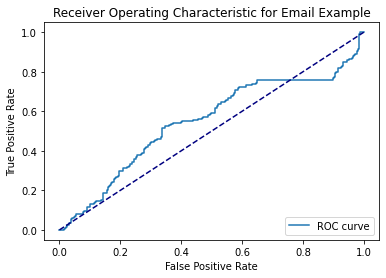

In [145]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots()
plt.plot(tpr,fpr,label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Email Example')
plt.legend(loc="lower right")
plt.show()